## 数据探索

In [1]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import *
mpl.rcParams['font.sans-serif']=['SimHei']
funddata = pd.read_csv("../data/user_balance_table.csv")
# 将目标列读取为日期型
funddata['report_date'] = pd.to_datetime(funddata['report_date'], format='%Y%m%d') 
# 对相同日期的资金申购量进行统计  
combine = funddata.groupby(['report_date']).agg({'total_purchase_amt': sum}) 
combine

total_purchase_amt
report_date                    
2013-07-01             32488348
2013-07-02             29037390
2013-07-03             27270770
2013-07-04             18321185
2013-07-05             11648749
...                         ...
2014-08-27            302194801
2014-08-28            245082751
2014-08-29            267554713
2014-08-30            199708772
2014-08-31            275090213

[427 rows x 1 columns]

In [2]:
plt.rcParams['axes.unicode_minus']=False
combine.plot(legend=False) 
plt.title('时序图')
plt.show()
plot_acf(combine)
plt.title('自相关图')
plt.show()

## 数据预处理

             total_purchase_amt
report_date                    
2014-03-01            362865580
2014-03-02            276202230
2014-03-03            505305862
2014-03-04            524146340
2014-03-05            454295491
...                         ...
2014-07-27            151406251
2014-07-28            371762756
2014-07-29            228093046
2014-07-30            209917272
2014-07-31            191728916

[153 rows x 1 columns]


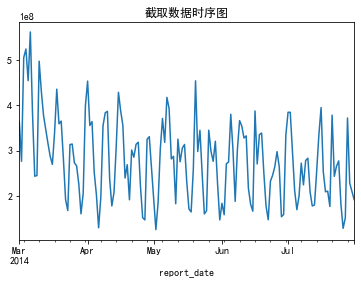

In [3]:
# 截取平稳部分数据
smooth = combine['2014-3':'2014-7']  
print(smooth)
smooth .plot(legend=False)  # 截取数据的时序图
plt.title('截取数据时序图')
plt.show()  # 截取的训练数据自相关图
plot_acf(smooth )
plt.title('截取数据自相关图')
plt.show()

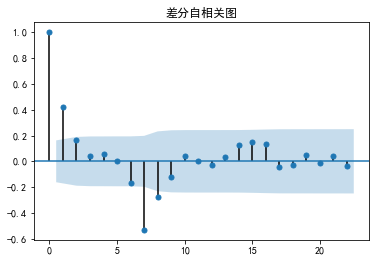

In [4]:
# 周期性差分
diffresult = smooth .diff(7)
diffresult.plot(legend=False)
diffresult = diffresult['2014-03-08':'2014-07-31']  # 需要进行数据的提取
plt.title('差分时序图')
plt.show()  # 差分时序图
plot_acf(diffresult)  # 差分数据自相关图
plt.title('差分自相关图')
plt.show()

In [5]:
# ADF检验
from statsmodels.tsa.stattools import adfuller as ADF
print('差分序列的ADF检验结果为：', ADF(diffresult))
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print('差分序列的白噪声检验结果为：', acorr_ljungbox(diffresult, lags=1))

差分序列的ADF检验结果为： (-3.949706067525637, 0.0016980133887242394, 14, 131, {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}, 5077.645620248397)
差分序列的白噪声检验结果为： (array([26.50345968]), array([2.63066558e-07]))


D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


## 分析与建模

In [6]:
import statsmodels.api as sm
# 模型定阶
train_results = sm.tsa.arma_order_select_ic(smooth, ic=['bic'], trend='nc', max_ar=5, max_ma=5)
print('BIC', train_results.bic_min_order)

D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\DELL\AppData\anaconda3\lib\site-packages\

BIC (3, 4)


D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<Figure size 864x576 with 0 Axes>

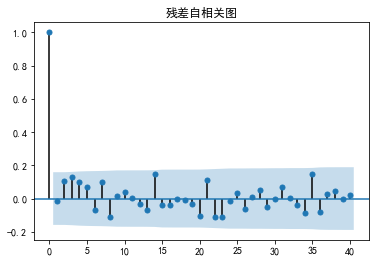

差分序列的白噪声检验结果为： (array([0.03654365]), array([0.84839715]))


D:\DELL\AppData\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [7]:
# 模型检验
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
# 根据定阶结果构建ARIMA模型
model = ARIMA(smooth, order=(3, 1, 3))
results = model.fit();
resid = results.resid;
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40)
plt.title('残差自相关图')
plt.show()  # 绘制残差的自相关图
print('差分序列的白噪声检验结果为：', acorr_ljungbox(resid.values.squeeze(), lags=1))

## 模型评价

In [8]:
# 获取预测与真实值数据
predict_sunspots = results.predict(start=str('2014-08-01'), end=str('2014-08-31'), dynamic=False)
right_num=combine['2014-08-01':'2014-08-31']

# 预测值和实际值
predict_array=predict_sunspots.values.flatten()
right_num_array=right_num.values.flatten()

# 得到误差
error_new=np.abs(np.array(predict_array)-np.array(right_num_array))/np.array(right_num_array).flatten()
print(error_new)

# 得到得分
score_array=[]
for i in range(31):
    a=0
    error=abs(predict_array[i]-right_num_array[i])/right_num_array[i]
    if error>=0.3:
        a=0
    else:
        a=5*cos(10*pi*error/3)+5
    score_array.append(a)
print(score_array)

[0.4870984  0.02171681 0.2477509  0.14905175 0.14600184 0.19569564
 0.2159885  0.0191982  0.27653338 0.13231004 0.14132094 0.30863207
 0.32167718 0.16912889 0.02397832 0.0469754  0.50315255 0.04638673
 0.26871363 0.11979034 0.19632509 0.03020687 0.45170315 0.73328027
 0.08066432 0.10019886 0.14168629 0.22854101 0.10649153 0.02958789
 0.17885379]
[0, 9.871259096627663, 0.7299498170694667, 5.049649389736282, 5.209281771795838, 2.6976544684858186, 1.8133442054743072, 9.899294071329683, 0.15021438296813283, 5.920955641215485, 5.453809296932777, 0, 0, 4.0050988233674385, 9.843197920823886, 9.407125837035998, 0, 9.42160019760184, 0.2659617826996401, 6.5555216926321025, 2.668448467339688, 9.751924264603044, 0, 0, 8.319722930173192, 7.4909771816427995, 5.434755179038178, 1.3358240205777179, 7.200094197303946, 9.761906299621806, 3.5121028263654708]


In [9]:
# 绘制真实值和预测值的对比图
fig, ax = plt.subplots(figsize=(7,4 ))
combine['2014-08'].plot(ax=ax)
predict_sunspots.plot(ax=ax,style='r--')
plt.rcParams['axes.unicode_minus']=False
plt.legend(labels=["真实值","预测值"])
plt.title('对比图')
plt.show()  